In [1]:
import tables_io
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from rail.raruma import utility_functions as raruma_util
from rail.raruma import plotting_functions as raruma_plot
from rail.raruma import admixture_functions as raruma_admix
from rail.raruma import wrapper_classes as raruma_wrap
from scipy.stats import sigmaclip
from astropy.stats import biweight_location, biweight_scale


In [2]:
# pz_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1'  
# if that fails you can use this
# pz_dir = '/global/u2/e/echarles/dx'
pz_dir = '/Users/echarles/pz'

In [3]:
train = tables_io.read(f"{pz_dir}/data/train/dp1_ecdfs_matched_specgold_train.hdf5")
test = tables_io.read(f"{pz_dir}/data/test/dp1_ecdfs_matched_specgold_test.hdf5")
#d.keys()
#train = tables_io.sliceObj(d, slice(0, -1, 10))
#test = tables_io.sliceObj(d, slice(1, -1, 10))
model_file_knn = './model_inform_knn.pkl'
model_file_bpz = './model_inform_bpz.pkl'
model_file_fzb = './model_inform_fzboost.pkl'
model_file_gpz = './model_inform_gpz.pkl'

In [4]:
from rail.estimation.algos.k_nearneigh import KNearNeighEstimator
from rail.estimation.algos.bpz_lite import BPZliteEstimator
from rail.estimation.algos.flexzboost import FlexZBoostEstimator
from rail.estimation.algos.gpz import GPzEstimator
from rail.utils.catalog_utils import RubinCatalogConfig
RubinCatalogConfig.apply(RubinCatalogConfig.tag)
band_names = raruma_util.make_band_names('LSST_obs_{band}', 'ugrizy')
error_band_names = raruma_util.make_band_names('LSST_obs_{band}_err', 'ugrizy')

In [5]:
train_features = raruma_util.get_band_values(train, '{band}_gaap1p0Mag', 'ugrizy')
error_bands = raruma_util.get_band_values(train, '{band}_gaap1p0MagErr', 'ugrizy')

In [6]:
knn = KNearNeighEstimator.make_stage(name='knn', model=model_file_knn, input='dummy.in', output_mode='return', nzbins=3001)
knn.stage_columns = knn.config.bands
knn_w = raruma_wrap.CatEstimatorWrapper(knn, band_names)

Inserting handle into data store.  model: ./model_inform_knn.pkl, knn


In [7]:
noise_grid = np.logspace(-4, 0, 17)

In [8]:
def doit(wrapper, nclip=3):
    the_dict = {}
    inputs = np.hstack([train_features, error_bands])
    est_orig = wrapper(inputs.T)
    means = []
    stds = []
    outlier_fracs = []
    biweight_means = []
    biweight_stds = []
    clipped_fracs = []
    
    for noise in noise_grid:
        noisy_mags = raruma_admix.gaussian_noise(train_features, noise_levels=noise*np.ones(6)).T
        inputs = np.hstack([noisy_mags, error_bands])
        ad_vals = wrapper(inputs.T)
        deltas = (ad_vals - est_orig)/(1 + est_orig)
        subset_clip, _, _ = sigmaclip(deltas, low=3, high=3)
        for _j in range(nclip):
            subset_clip, _, _ = sigmaclip(subset_clip, low=3, high=3)

        the_dict[noise] = deltas
        clipped_fracs.append((len(deltas) - len(subset_clip))/(len(deltas)))
        outliers = (np.fabs(deltas) > 0.15).sum() / float(deltas.size)
        outlier_fracs.append(outliers)
        means.append(deltas.mean())
        stds.append(deltas.std())
        biweight_means.append(biweight_location(subset_clip))
        biweight_stds.append(biweight_scale(subset_clip))
    
    _ = plt.plot(noise_grid, means, label=r"mean $\delta z$", ls='-.', color='blue')
    _ = plt.plot(noise_grid, stds, label=r"RMS $\delta z$", ls='-.', color='green')
    _ = plt.plot(noise_grid, biweight_means, label=r"biweight mean $\delta z$", ls='-', color='blue')
    _ = plt.plot(noise_grid, biweight_stds, label=r"biweight RMS $\delta z$", ls='-', color='green')    
    _ = plt.plot(noise_grid, outlier_fracs, label=r"f $\frac{\delta z}{1+z} > 0.15$", ls='-', color='cyan')
#    _ = plt.plot(admix_grid, clipped_fracs, label=r"$f_{\rm outlier}$", ls='-.', color='cyan')
    _ = plt.xscale('log')
    _ = plt.legend()
    _ = plt.xlabel("Noise [mag]")
    _ = plt.ylabel(r"$\delta z$")

Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hd

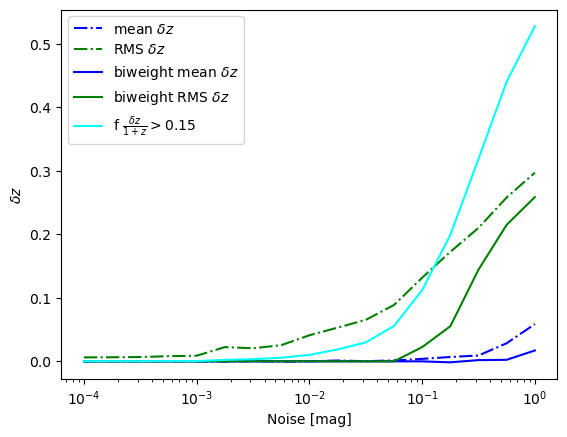

In [9]:
doit(knn_w)